# Adding groundwater pumping
*Developed by R.A. Collenteur & M. Bakker*

In this example notebook it is shown how to simulate the effect of a pumping well on the groundwater levels. We will first create a TFN model with the net recharge as the single stress used to explain the observed heads. Second, this model is extended to include the effect of a pumping well on the heads by adding another stress model. The simulated heads are compared and it can be clearly seen how the addition of the pumping well improves the simulation of the heads.

This example was also shown at the 2018 General Assembly of the European Geophysical Union:

Bakker, M., Collenteur, R., Calje, F. Schaars (2018) [Untangling groundwater head series using time series analysis and Pastas](https://meetingorganizer.copernicus.org/EGU2018/EGU2018-7194.pdf). In EGU General Assembly 2018.


In [1]:
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

ps.show_versions()

Python version: 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:37:09) 
[Clang 10.0.1 ]
Numpy version: 1.18.5
Scipy version: 1.4.0
Pandas version: 1.1.2
Pastas version: 0.16.0b
Matplotlib version: 3.1.3


## 1. Read the time series from files
All time series for this example have been prepared as csv-files, which are read using the Pandas `read_csv`- method. The following time series are available:

- heads in meters above the Dutch National Datum (NAP), irregular time steps
- rain in m/d
- Makkink reference evaporation in m/d
- Pumping extraction rate in m$^3$/d. The pumping well stopped operating after 2012.

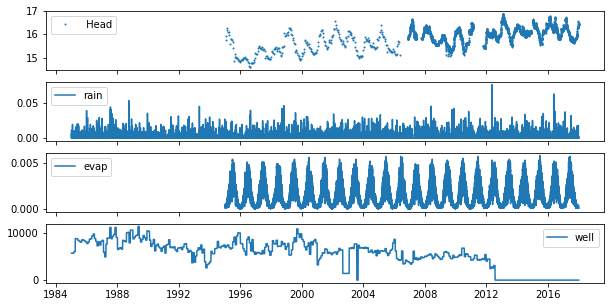

In [2]:
head = pd.read_csv("data_notebook_5/head_wellex.csv", 
                   index_col="Date", parse_dates=True, squeeze=True)
rain =  pd.read_csv("data_notebook_5/prec_wellex.csv", 
                    index_col="Date", parse_dates=True)
evap =  pd.read_csv("data_notebook_5/evap_wellex.csv", 
                    index_col="Date", parse_dates=True)
well =  pd.read_csv("data_notebook_5/well_wellex.csv", 
                    index_col="Date", parse_dates=True)

# Make a plot of all the time series
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(10,5));
ax[0].plot(head, label=head.name, linestyle=" ", marker=".", markersize=2)
ax[0].legend()
ax[1].plot(rain, label="rain")
ax[1].legend()
ax[2].plot(evap, label="evap")
ax[2].legend()
ax[3].plot(well, label="well")
ax[3].legend()

## 2. Create a Pastas Model
A pastas Model is created. A constant and a noisemodel are automatically added. The effect of the net groundwater recharge $R(t)$ is simulated using the `ps.RechargeModel` stress model. Net recharge is calculated as $R(t) = P(t) - f * E(t)$ where $f$ is a parameter that is estimated and $P(t)$ and $E(t)$ are precipitation and reference evapotranspiration, respectively. 

INFO: Cannot determine frequency of series  Head: freq=None. The time series is irregular.
INFO: Inferred frequency for time series  Prec: freq=D
INFO: Inferred frequency for time series  Evap: freq=D
INFO: Time Series  Evap was extended to 1985-01-16 00:00:00 with the mean value of the time series.


Fit report groundwater           Fit Statistics
nfev     25                     EVP          51.79
nobs     3869                   R2            0.12
noise    True                   RMSE          0.33
tmin     1995-01-14 00:00:00    AIC          -2.10
tmax     2018-01-12 00:00:00    BIC          29.20
freq     D                      Obj           1.95
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           Interpolated    No

Parameters (5 were optimized)
                optimal   stderr     initial  vary
recharge_A   835.822437  ±62.49%  203.104730  True
recharge_a   540.839625  ±62.19%   10.000000  True
recharge_f    -1.940472  ±11.00%   -1.000000  True
constant_d    16.511745   ±3.23%   15.975755  True
noise_alpha  281.723634  ±27.23%    1.000000  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  1.00
           constant_d  0.83
recharge_a constant_d  0.86


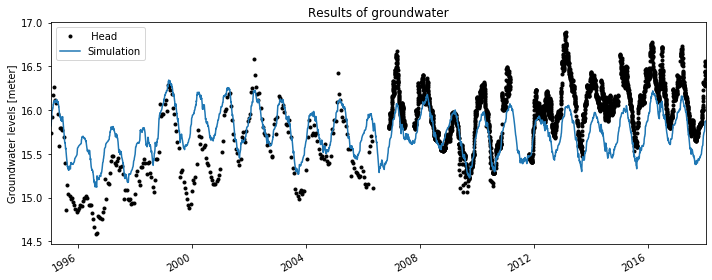

In [3]:
# Create the time series model
ml = ps.Model(head, name="groundwater")

# Add the stres model for the net recharge
rm = ps.RechargeModel(rain, evap, name="recharge", 
                      rfunc=ps.Exponential, recharge=ps.rch.Linear())
ml.add_stressmodel(rm)
ml.solve(noise=True)
ml.plot(figsize=(10,4))

# Let's store the simulated values to compare later
sim1 = ml.simulate()
res1 = ml.residuals()
n1 = ml.noise()

**Interpreting the results**

As can be seen from the above plot, the observed heads show a clear rise whereas the simulated heads do not show this behaviour. The rise in the heads cannot be explained by an increased precipitation or a decreased evaporation over time, and it is likely another force is driving the heads upwards. Given the location of the well, we can hypothesize that the groundwater pumping caused a lowering of the heads in the beginning of the observations, which decreased when the pumping well was shut down. A next logical step is to add the effect of the pumping well and see if it improves the simulation of the head.

## 3. Add the effect of the pumping well
To simulate the effect of the pumping well a new stress model is added. The effect of the well is simulated using the `ps.StressModel`, which convoluted a stress with a response function. As a response function the `ps.Hantush` response function is used. The keyword-argument `up=False` is provided to tell the model this stress is supposed to have a lowering effect on the groundwater levels.

INFO: Inferred frequency for time series  Well: freq=D


Fit report groundwater           Fit Statistics
nfev     24                     EVP          74.96
nobs     3869                   R2            0.74
noise    True                   RMSE          0.18
tmin     1995-01-14 00:00:00    AIC           6.35
tmax     2018-01-12 00:00:00    BIC          56.44
freq     D                      Obj           1.93
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           Interpolated    No

Parameters (8 were optimized)
                optimal   stderr     initial  vary
recharge_A   718.943898  ±27.99%  203.104730  True
recharge_a   448.480751  ±28.07%   10.000000  True
recharge_f    -1.864180   ±9.75%   -1.000000  True
well_A      -102.841843   ±9.58% -338.167845  True
well_n         1.286498  ±33.95%    1.000000  True
well_a        75.864224  ±57.75%   10.000000  True
constant_d    16.773074   ±1.53%   15.975755  True
noise_alpha   82.906003  ±15.38%    1.000000  True

Parameter correlations |rho| > 0.5
recharge_A recharg

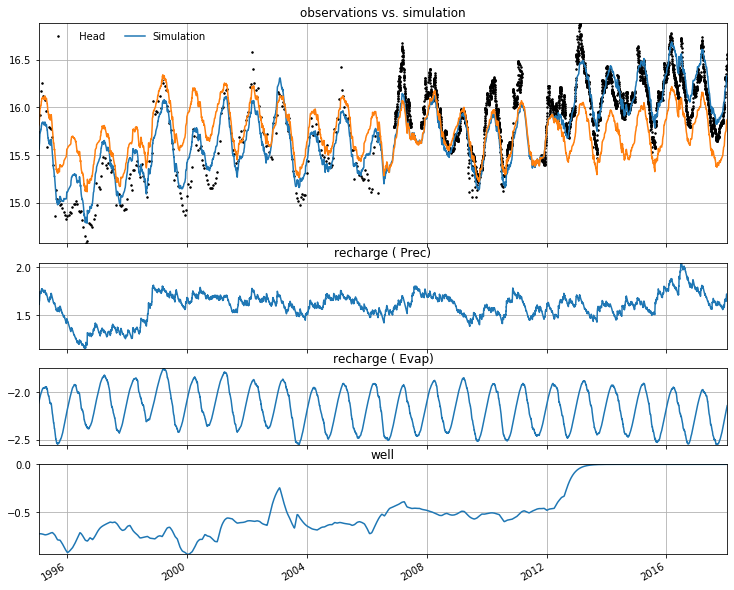

In [4]:
# Add the stress model for the pumping well
sm = ps.StressModel(well/1e6, rfunc=ps.Gamma, name="well", settings="well", up=False)
ml.add_stressmodel(sm)

# Solve the model and make a plot
ml.solve()
axes = ml.plots.decomposition(figsize=(10,8))
axes[0].plot(sim1) # Add the previously simulated values to the plot

**Interpreting the results**

The addition of the pumping well to simulate the heads clearly improved the fit with the observed heads. It can also be seen how the pumping well stops contributing to the lowering of the head after ~2014, indicating the pumping effect of the well has dampened out. The period it takes before the historic pumping has no effect anymore can be approximated by the length of the response function for the well (e.g., `len(ml.get_step_response("well"))`).

## 4. Analyzing the residuals
The difference between the model with and without the pumping becomes even more clear when analyzing the model residuals. The residuals of the model without the well show a clear upward trend, whereas the model with a model does not show this trend anymore.

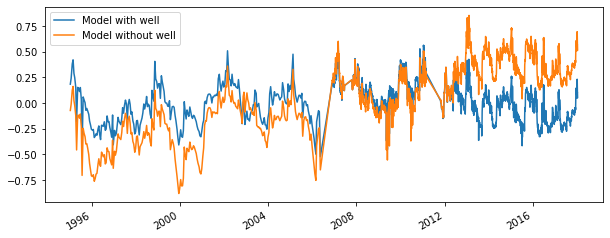

In [5]:
ml.residuals().plot(figsize=(10, 4))
res1.plot()
plt.legend(["Model with well", "Model without well"])